## Importing dependancies

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import string
from nltk.corpus import stopwords
from collections import Counter
from gensim.models import word2vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import KeyedVectors
from gensim.models import fasttext
import keras
import time
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
nltk.download('stopwords')


## Loading the data

In [2]:
import gzip
import pandas as pd

def parse(path):
    with gzip.open(path, 'rb') as g:
        for l in g:
            # Replace 'true' with 'True' and 'false' with 'False' before evaluating
            yield eval(l.replace(b'true', b'True').replace(b'false', b'False'))

def getDF(path):
    df = {}
    for i, d in enumerate(parse(path)):
        df[i] = d
    return pd.DataFrame.from_dict(df, orient='index')


In [3]:
df_1 = getDF('Office_Products.json.gz')
df_1.shape

(5581313, 12)

Making sure the proportions of bad and good reviwes are similar
For original dataset of 5M rows
5.0    0.644351
4.0    0.138759
1.0    0.101003
3.0    0.068285
2.0    0.047602
Name: overall, dtype: float64
For sampled dataset of 200k rows
5.0    0.643665
4.0    0.139935
1.0    0.101055
3.0    0.068055
2.0    0.047290
Name: overall, dtype: float64


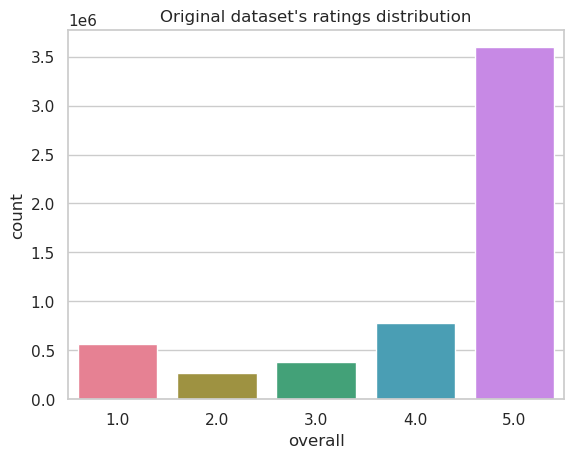

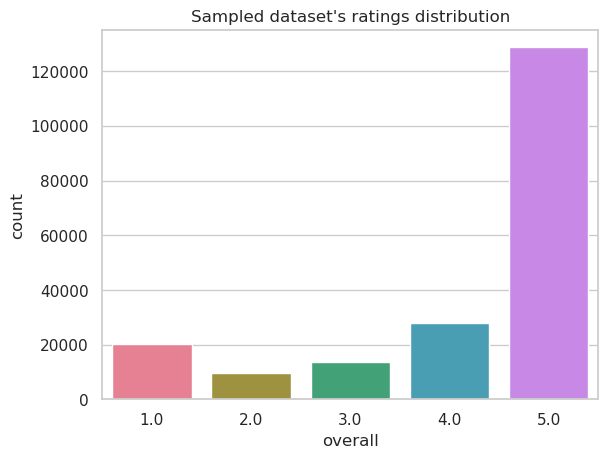

In [7]:
# Sampling 200,000 rows for the assignment
df_4 = df_1.sample(n=200000, random_state=42)
# Making sure the proportions of bad and good reviwes are similar
print("Making sure the proportions of bad and good reviwes are similar")
print("For original dataset of 5M rows")
print(df_1['overall'].value_counts(normalize=True))
print("For sampled dataset of 200k rows")
print(df_4['overall'].value_counts(normalize=True))

# Visualizing the distribution of the ratings
sns.set(style="whitegrid")
# Create a count plot of the ratings
plt.title("Original dataset's ratings distribution")
sns.countplot(x='overall', data=df_1, palette='husl')
# Display the plot
plt.show()

plt.title("Sampled dataset's ratings distribution")
sns.countplot(x='overall', data=df_4, palette='husl')
# Display the plot
plt.show()

In [8]:
# Storing the text from the reviews
# Taking a look at the reviews alone
merged_df = df_4
merged_text = merged_df['reviewText']
merged_df['reviewText']

2725239    A little messy at first because the ink did bl...
3571099    I bought this product for my granddaughters Ch...
1486099    Great price exactly what I wanted.  Seem very ...
174904                                 Really well designed.
2438927    These Sharpie Markers are perfect for office u...
                                 ...                        
2102565    Very sturdy storage boxes. Perfect for my reco...
243015                                            Great pen!
2785263    I love this keyboard cover. It fits my MacBook...
5012808    It does the job.  I always get these shiba cal...
4020933    I like the pens but the black one leaked right...
Name: reviewText, Length: 200000, dtype: object

## Text Preprocessing and creating the vocabulary

In [9]:
# split the text into words
def split_text(text):
    text = str(text)
    return text.split()

# remove the punctuation
def remove_punctuation(text):
    import string
    table = str.maketrans('', '', string.punctuation)
    words = [w.translate(table) for w in text]
    return words

# remove the non-alphabetic tokens
def remove_non_alphabetic(tokens):
    return [word for word in tokens if word.isalpha()]

# convert the words to lower case
def to_lower_case(tokens):
    return [word.lower() for word in tokens]

# remove the stop words
def remove_stop_words(tokens):
    stop_words = set(stopwords.words('english'))
    return [word for word in tokens if word not in stop_words]

# remove the words that appear only once
def remove_single_occurrence_words(tokens):
    word_counts = Counter(tokens)
    return [word for word in tokens if word_counts[word] > 1]
# remove short words
def remove_short_words(tokens):
    return [word for word in tokens if len(word) > 1]

# create a vocabulary
def create_vocabulary(text):
    tokens = split_text(text)
    tokens = remove_punctuation(tokens)
    tokens = remove_non_alphabetic(tokens)
    tokens = to_lower_case(tokens)
    tokens = remove_stop_words(tokens)
    tokens = remove_single_occurrence_words(tokens)
    return tokens


In [10]:
text_1 = merged_text.astype(str)
text_1.fillna('0', inplace=True)

In [11]:
text_vocabulary=[]
for text in text_1:
    text_vocabulary += create_vocabulary(text)

In [12]:
# create the vocabulary for the first dataset
merged_df['cleaned_text'] = merged_df['reviewText'].apply(create_vocabulary)

## Helper functions


### Convert ratings to just positive, negative and neutral

In [13]:
def convert_ratings(rating):
    if rating == 4.0 or rating == 5.0:
        return 1
    elif rating == 1.0 or rating == 2.0:
        return 0
    else:
        return 3

# Apply the function to the overall column
merged_df['overall'] = merged_df['overall'].apply(convert_ratings)
print("Distribution of overall ratings after encoding")
merged_df['overall'].value_counts()

Distribution of overall ratings after encoding


1    156720
0     29669
3     13611
Name: overall, dtype: int64

### Creating mean vectors for each row

In [15]:
# Create an empty list to store the mean vectors
def create_mean_vectors(model_name, data_frame, column_name):
    mean_vectors = []
    for index, row in data_frame.iterrows():
        words = row[column_name]
        word_vectors = []
        for word in words:
            if word in model_name.wv:
                vector = model_name.wv[word]
                word_vectors.append(vector)
        if word_vectors:
            mean_vector = np.mean(word_vectors, axis=0)
            mean_vectors.append(mean_vector)
        else:
            mean_vectors.append(np.zeros(300))
    mean_vectors = np.array(mean_vectors)
    return mean_vectors

# For fasttext
def create_mean_vectors_fasttext(model_name, data_frame, column_name):
    mean_vectors = []
    for index, row in data_frame.iterrows():
        words = row[column_name]
        word_vectors = []
        for word in words:
            # if word in model_name:
            vector = model_name[word]
            word_vectors.append(vector)
        if word_vectors:
            mean_vector = np.mean(word_vectors, axis=0)
            mean_vectors.append(mean_vector)
        else:
            mean_vectors.append(np.zeros(300))
    mean_vectors = np.array(mean_vectors)
    return mean_vectors

# Create a DataFrame with the new mean columns
def create_mean_columns(mean_vectors, data_frame):
    mean_columns = pd.DataFrame(mean_vectors, columns=['mean_vector_' + str(i) for i in range(1,mean_vectors.shape[1]+1)])
    mean_columns.index = data_frame.index
    return mean_columns

def create_new_df(mean_vectors, data_frame):
    new_df = pd.concat([mean_vectors, data_frame['overall']], axis=1)
    return new_df

def drop_ratings_3(data_frame):
    data_frame = data_frame[data_frame['overall'] != 3]
    return data_frame

def drop_overall_column(data_frame):
    saved_overall = data_frame['overall']
    data_frame = data_frame.drop('overall', axis=1)
    return data_frame, saved_overall

## Getting embedding models - Word2Vec(cbow + sg) + Fasstext

#### Continuous Bag of Words (CBOW)

In [16]:
print(time.strftime("%H:%M:%S", time.gmtime()))
print('Training the cbow model')
model_cb = word2vec.Word2Vec(sentences=[text_vocabulary],  window = 3 ,epochs = 100, vector_size=300,  min_count=2)
print(time.strftime("%H:%M:%S", time.gmtime()))
vocab = set(text_vocabulary)
print("Number of words in the vocabulary: ", len(vocab))
print("Number of words in the model: ", len(model_cb.wv.index_to_key))
#   -----------------------------------------------------------------
# get the similarity between two words
#   -----------------------------------------------------------------
print(model_cb.wv.most_similar('windows', topn=5))

print(model_cb.wv.similarity('windows', 'messages'))

21:16:19
Training the cbow model
21:16:22
Number of words in the vocabulary:  12014
Number of words in the model:  12014
[('computer', 0.836020827293396), ('linkyo', 0.7365187406539917), ('problems', 0.7319079637527466), ('cddvd', 0.7076230049133301), ('love', 0.7032081484794617)]
0.28948247


### Skipgram

In [17]:
print(time.strftime("%H:%M:%S", time.gmtime()))
print('Training the skipgram model')
model_sg = word2vec.Word2Vec(sentences=[text_vocabulary], sg=1, window = 3 ,epochs = 100, vector_size=300,  min_count=2)
print(time.strftime("%H:%M:%S", time.gmtime()))
vocab = set(text_vocabulary)
print("Number of words in the vocabulary: ", len(vocab))
print("Number of words in the model: ", len(model_sg.wv.index_to_key))
#   -----------------------------------------------------------------
# get the similarity between two words
#   -----------------------------------------------------------------
print(model_sg.wv.most_similar('windows', topn=5))

21:16:29
Training the skipgram model
21:16:35
Number of words in the vocabulary:  12014
Number of words in the model:  12014
[('encountered', 0.814810574054718), ('fact', 0.8005079030990601), ('reviewers', 0.7971938252449036), ('problems', 0.7896595001220703), ('cddvd', 0.7834711670875549)]


### Fasttext

In [18]:
from gensim.models import fasttext

# Path to the pretrained model files
model_bin_path = "crawl-300d-2M-subword.bin"
model_ft = fasttext.load_facebook_model(model_bin_path)

# We will use this model to obtain contextual embeddings based off our review data set

## Load embeddings into design dataframes and target dataframes 

### Cbow

In [19]:
mean_vectors_cb1 = create_mean_vectors(model_cb, merged_df, 'cleaned_text')

mean_columns1 = create_mean_columns(mean_vectors_cb1, merged_df)

new_df1 = create_new_df(mean_columns1, merged_df)

new_df1 = drop_ratings_3(new_df1)

new_df1, saved_overall1 = drop_overall_column(new_df1)

### Skipgram

In [20]:
mean_vectors_sg1 = create_mean_vectors(model_sg, merged_df, 'cleaned_text')

mean_columns2 = create_mean_columns(mean_vectors_sg1, merged_df)

new_df2 = create_new_df(mean_columns2, merged_df)

new_df2 = drop_ratings_3(new_df2)

new_df2, saved_overall2 = drop_overall_column(new_df2)

### Fasttext

In [21]:
mean_vectors_ft = create_mean_vectors_fasttext(model_ft.wv, merged_df, 'cleaned_text')

mean_columns3 = create_mean_columns(mean_vectors_ft, merged_df)

new_df3 = create_new_df(mean_columns3, merged_df)

new_df3 = drop_ratings_3(new_df3)

new_df3, saved_overall3 = drop_overall_column(new_df3)

## A general EDA on the reviews and 3 embeddings obtained

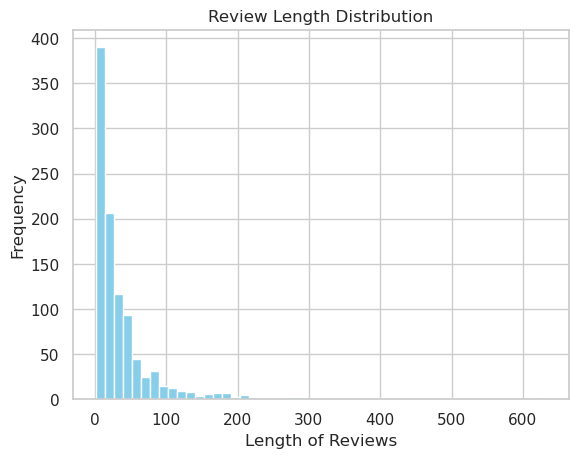

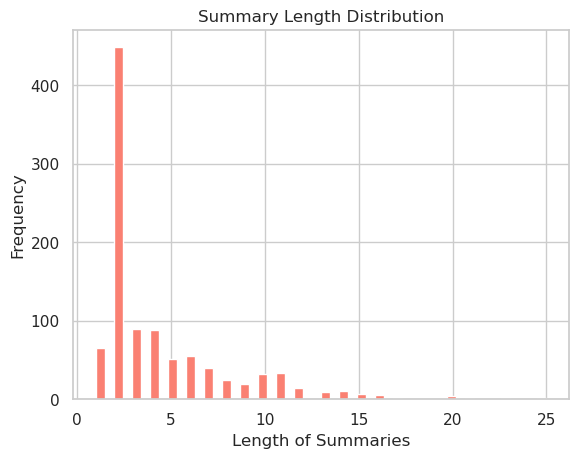

In [82]:
df["length_review"] = merged_df["reviewText"].apply(lambda x: len(str(x).split()))
df["length_summary"] = merged_df["summary"].apply(lambda x: len(str(x).split()))
 
import matplotlib.pyplot as plt
# Plotting Review Length Distribution
 
def plot_review_length_distribution():
 
    plt.hist(df['length_review'], bins=50, color='skyblue')
 
    plt.title('Review Length Distribution')
 
    plt.xlabel('Length of Reviews')
 
    plt.ylabel('Frequency')
 
    plt.show()
plot_review_length_distribution()
 
 
# Plotting Summary Length Distribution
def plot_summary_length_distribution():
    plt.hist(df['length_summary'], bins=50, color='salmon')
    plt.title('Summary Length Distribution')
    plt.xlabel('Length of Summaries')
    plt.ylabel('Frequency')
    plt.show()
plot_summary_length_distribution()

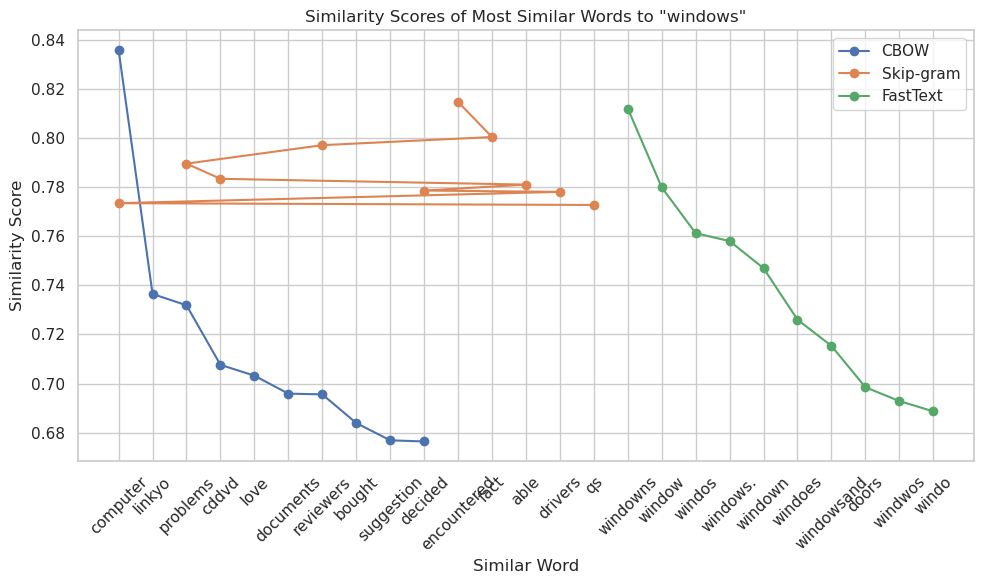

In [85]:
import matplotlib.pyplot as plt
 
# Function to get most similar words and their similarity scores
def get_similar_words(model, word):
    similar_words = model.wv.most_similar(word)
    words = [w[0] for w in similar_words]
    scores = [w[1] for w in similar_words]
    return words, scores
 
# Get most similar words and scores for "windows" from CBOW, Skip-gram, and FastText models
cbow_words, cbow_scores = get_similar_words(model_cb, "windows")
sg_words, sg_scores = get_similar_words(model_sg, "windows")
fasttext_words, fasttext_scores = get_similar_words(model_ft, "windows")
 
# Plot the graph
plt.figure(figsize=(10, 6))
plt.plot(cbow_words, cbow_scores, marker='o', linestyle='-', label='CBOW')
plt.plot(sg_words, sg_scores, marker='o', linestyle='-', label='Skip-gram')
plt.plot(fasttext_words, fasttext_scores, marker='o', linestyle='-', label='FastText')
plt.xlabel('Similar Word')
plt.ylabel('Similarity Score')
plt.title('Similarity Scores of Most Similar Words to "windows"')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## PCA dimensionality reduction -> final X and y for machine learning

In [22]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

def final_data(new_df,saved_overall,name):
    
    #Initialize PCA
    pca = PCA(n_components=0.90, random_state=42)
    red_data = pca.fit_transform(new_df)
    
    # To find best n_components for pca - Calculate the cumulative explained variance
    cumulative_variance = pca.explained_variance_ratio_.cumsum()
    
    # Plot the cumulative explained variance
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Cumulative Explained Variance vs. Number of Principal Components')
    plt.grid()
    plt.show()
    
    # Find best n_components
    explained_variance_threshold = 0.75
    n_components = np.argmax(cumulative_variance >= explained_variance_threshold) + 1
    print(f"Number of PCA components selected for {name}= {n_components}")
    
    # Use best n_components and reduce the features
    pca = PCA(n_components=n_components, random_state=42)
    final_reduced_data = pca.fit_transform(new_df)
    final_reduced_data = pd.DataFrame(final_reduced_data, columns=['PC' + str(i) for i in range(1,n_components+1)])
    final_reduced_data.index = new_df.index
    final_data = pd.concat([final_reduced_data, saved_overall], axis=1)
    print("----------------------------------------")
    return final_data

Dimension reduction for CBOW


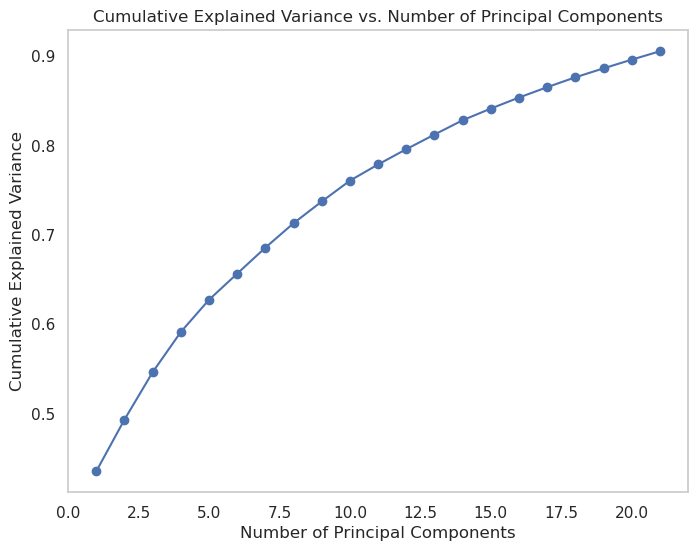

Number of PCA components selected for cbow= 10
----------------------------------------
Dimension reduction for Skipgram


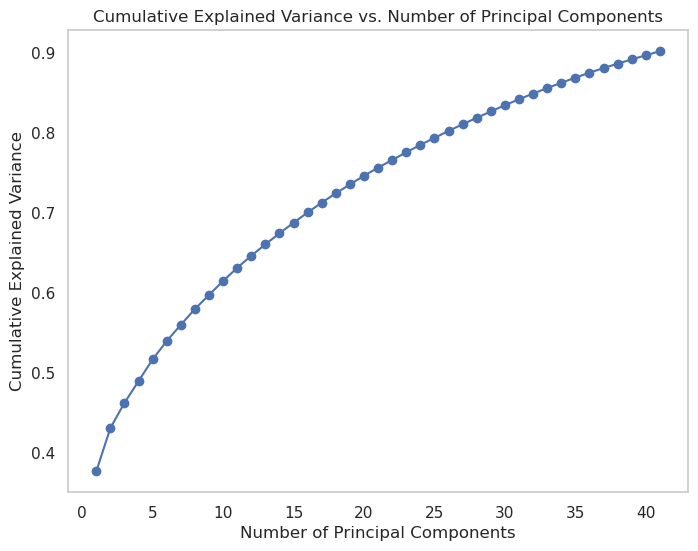

Number of PCA components selected for skipgram= 21
----------------------------------------
Dimension reduction for Fasttext


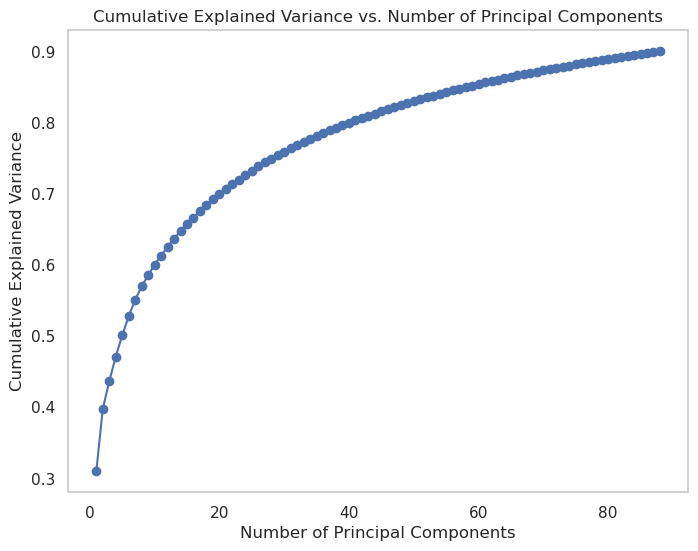

Number of PCA components selected for fasttext= 29
----------------------------------------


In [23]:
print("Dimension reduction for CBOW")
cb_final_data = final_data(new_df1,saved_overall1, "cbow")
print("Dimension reduction for Skipgram")
sg_final_data = final_data(new_df2,saved_overall2, "skipgram")
print("Dimension reduction for Fasttext")
ft_final_data = final_data(new_df3,saved_overall3, "fasttext")

### Split train+test data

In [24]:
from sklearn.model_selection import train_test_split

def split_data(final_data):
    X = final_data.drop('overall', axis=1)
    y = final_data['overall']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    return X_train, X_test, y_train, y_test

X_train_cb, X_test_cb, y_train_cb, y_test_cb = split_data(cb_final_data)
X_train_sg, X_test_sg, y_train_sg, y_test_sg = split_data(sg_final_data)
X_train_ft, X_test_ft, y_train_ft, y_test_ft = split_data(ft_final_data)

## Classification models

In [88]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from keras.optimizers import Adam
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from keras.utils import set_random_seed
from sklearn.utils.class_weight import compute_sample_weight
import numpy as np
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import LSTM
from keras.layers import Embedding
from keras.preprocessing import sequence
from keras.layers import Dropout
from keras.layers import Bidirectional
from keras.layers import SimpleRNN
set_random_seed(42)

def log_reg(X_train, X_test, y_train, y_test, name):
    
        print(f"\t\t\tFOR {name} EMBEDDINGS")        
        # Create an instance of Logistic Regression model
        model = LogisticRegression()
        # Train the model on the training data
        model.fit(X_train, y_train)
        # Predict the labels for the test data
        y_pred = model.predict(X_test)
        # Calculate the accuracy of the model
        accuracy = accuracy_score(y_test, y_pred)
        # Calculate the precision of the model
        precision = precision_score(y_test, y_pred)
        # Calculate the recall of the model
        recall = recall_score(y_test, y_pred)
        # Calculate the F1 score of the model
        f1 = f1_score(y_test, y_pred)
        # ROC-AUC score
        roc_auc = roc_auc_score(y_test, y_pred)
        print("Accuracy:", accuracy)
        print("Precision:", precision)
        print("Recall:", recall)
        print("F1 Score:", f1)  
        print("ROC-AUC Score:", roc_auc)
        cnn_conf_matrix = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cnn_conf_matrix, annot=True, cmap='Oranges', fmt='d', cbar=False)
        plt.title(f'Confusion Matrix -{name} ')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
        print("--------------------------------------------")        

        
def random_forest(X_train, X_test, y_train, y_test, name):
        
        print(f"\t\t\tFOR {name} EMBEDDINGS")
        # Create an instance of the Random Forest classifier
        rf_classifier = RandomForestClassifier()
        # Fit the classifier to the training data
        rf_classifier.fit(X_train, y_train)
        # Predict the labels for the testing data
        y_pred = rf_classifier.predict(X_test)
        # Evaluate the performance of the classifier
        # Accuracy
        accuracy = accuracy_score(y_test, y_pred)
        # Precision
        precision = precision_score(y_test, y_pred)
        # Recall
        recall = recall_score(y_test, y_pred)
        # F1 score
        f1 = f1_score(y_test, y_pred)
        # ROC-AUC score
        roc_auc = roc_auc_score(y_test, y_pred)
        print("Accuracy:", accuracy)
        print("Precision:", precision)
        print("Recall:", recall)
        print("F1 Score:", f1)
        print("ROC-AUC Score:", roc_auc)
        cnn_conf_matrix = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cnn_conf_matrix, annot=True, cmap='Oranges', fmt='d', cbar=False)
        plt.title(f'Confusion Matrix -{name} ')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
        print("--------------------------------------------")        
       
        
def cnn(X_train, X_test, y_train, y_test, name):
    print(f"\t\t\tFOR {name} EMBEDDINGS")
    # Calculate class weights for binary classification
    class_weights = compute_sample_weight(class_weight='balanced', y=y_train)
    unique_classes = np.unique(y_train)
    class_weights_dict = {unique_classes[i]: np.mean(class_weights[y_train == unique_classes[i]]) for i in range(len(unique_classes))}
    print("Class weights: ", class_weights_dict)
    model = Sequential()
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))  # Added dropout
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))  # Added dropout
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(learning_rate=0.01)  # Adjusted learning rate
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    # Convert to numpy and reshape if not already done
    X_train = np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = np.array(X_test).reshape(X_test.shape[0], X_test.shape[1], 1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min', restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, mode='min', min_lr=0.0001)
    model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test), class_weight=class_weights_dict, callbacks=[early_stopping, reduce_lr])
    yhat_probs = model.predict(X_test, verbose=0)
    yhat_probs = yhat_probs[:, 0]
    y_pred = pd.Series(yhat_probs).apply(lambda x: 1 if x > 0.5 else 0)
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    cnn_conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cnn_conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False)
    plt.title(f'Confusion Matrix - CNN for {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()        

def rnn(X_train, X_test, y_train, y_test, name, units=32, output_dim=1, epochs=10, batch_size=32, class_weights=None):
    # Calculate class weights for binary classification
    class_weights = compute_sample_weight(class_weight='balanced', y=y_train)
    unique_classes = np.unique(y_train)
    class_weights_dict = {unique_classes[i]: np.mean(class_weights[y_train == unique_classes[i]]) for i in range(len(unique_classes))}
    print("Class weights: ", class_weights_dict)
    # Check and convert to NumPy arrays if necessary
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    # Assuming input_dim is the second dimension for RNN
    time_steps = 1  # Initialize time_steps to 1 for simplicity
    input_dim = X_train.shape[1]  # Number of features
    # Reshape data for RNN: [samples, time steps, features]
    X_train = X_train.reshape((X_train.shape[0], time_steps, input_dim))
    X_test = X_test.reshape((X_test.shape[0], time_steps, input_dim))
    print(f"Training RNN for {name} embeddings with time_steps: {time_steps} and input_dim: {input_dim}")
    # Build the RNN model
    model = Sequential()
    model.add(SimpleRNN(units, input_shape=(time_steps, input_dim), activation='relu'))
    model.add(Dropout(0.5))  # Added dropout for regularization
    model.add(Dense(output_dim, activation='sigmoid'))
    # Compile the model with an adjusted learning rate
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    # Early Stopping and ReduceLROnPlateau
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min', restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, mode='min', min_lr=0.0001)
    # Train the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), class_weight=class_weights_dict, callbacks=[early_stopping, reduce_lr])
    # Predict and evaluate
    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    rnn_conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(rnn_conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False)
    plt.title(f'Confusion Matrix - RNN for {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    

        

### Logistic regression

			FOR CBOW EMBEDDINGS
Accuracy: 0.8369815977251999
Precision: 0.8417507506695161
Recall: 0.9927577845839715
F1 Score: 0.9110392176955395
ROC-AUC Score: 0.5034567487126127


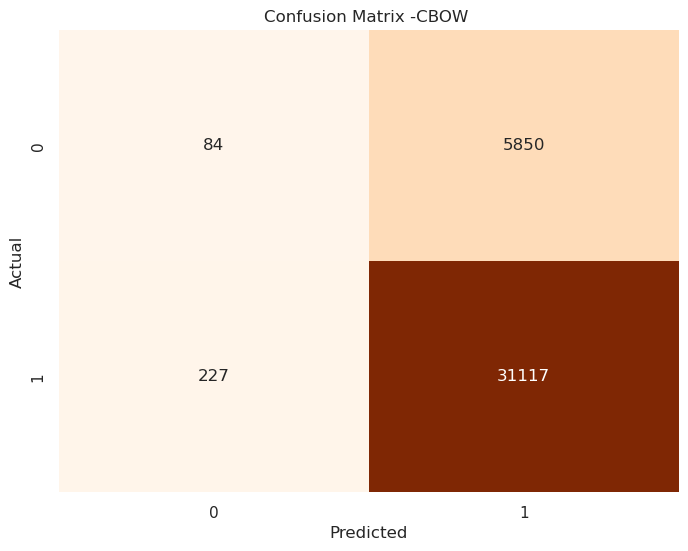

--------------------------------------------
			FOR Skipgram EMBEDDINGS
Accuracy: 0.8389130318150115
Precision: 0.842576318849201
Recall: 0.9941615620214395
F1 Score: 0.9121138056697938
ROC-AUC Score: 0.506517922904889


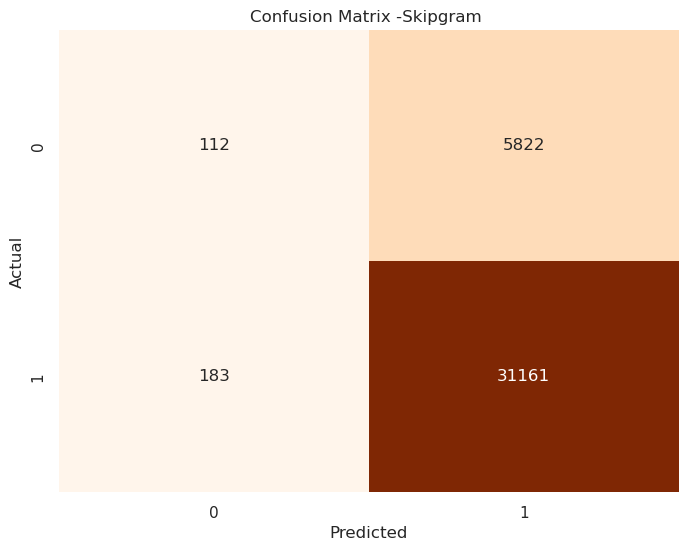

--------------------------------------------
			FOR Fasttext EMBEDDINGS
Accuracy: 0.836766993937443
Precision: 0.8421423346788395
Recall: 0.9917687595712098
F1 Score: 0.9108516342646176
ROC-AUC Score: 0.5049002207023559


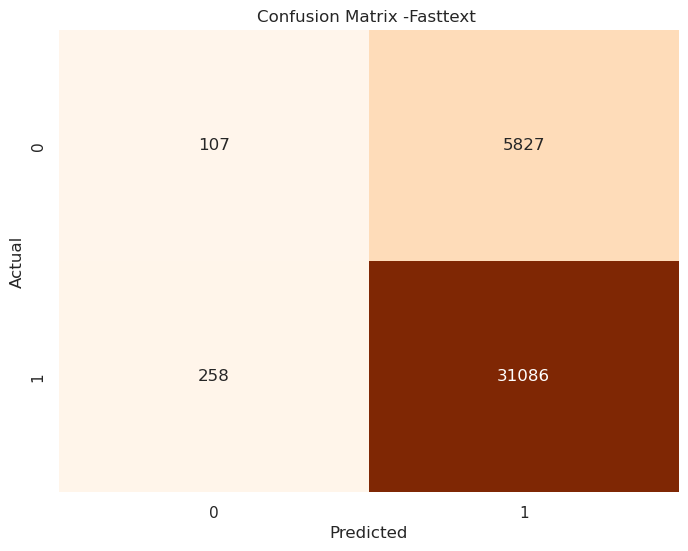

--------------------------------------------


In [87]:
log_reg(X_train_cb, X_test_cb, y_train_cb, y_test_cb, 'CBOW')
log_reg(X_train_sg, X_test_sg, y_train_sg, y_test_sg, 'Skipgram')
log_reg(X_train_ft, X_test_ft, y_train_ft, y_test_ft,'Fasttext')

### Random forest

			FOR CBOW EMBEDDINGS
Accuracy: 0.8414882772680938
Precision: 0.8501225119070561
Recall: 0.9851646248085758
F1 Score: 0.912675307018192
ROC-AUC Score: 0.533869808191278


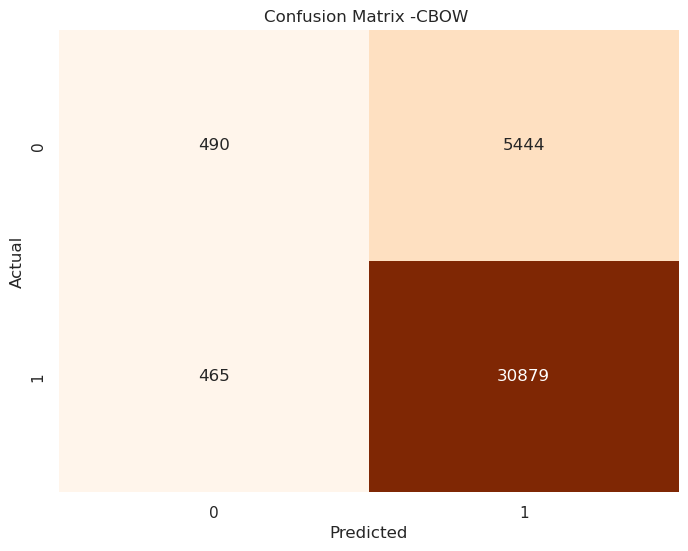

--------------------------------------------
			FOR Skipgram EMBEDDINGS
Accuracy: 0.842910027361983
Precision: 0.8500906543596506
Recall: 0.9872702909647779
F1 Score: 0.913559472145957
ROC-AUC Score: 0.5338272587280917


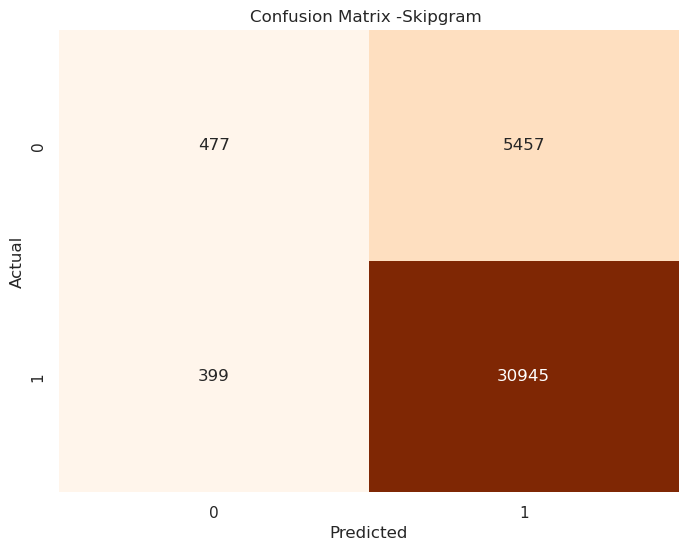

--------------------------------------------
			FOR Fasttext EMBEDDINGS
Accuracy: 0.845565749235474
Precision: 0.8511321531494442
Recall: 0.9893759571209801
F1 Score: 0.915062187403178
ROC-AUC Score: 0.5376606782571534


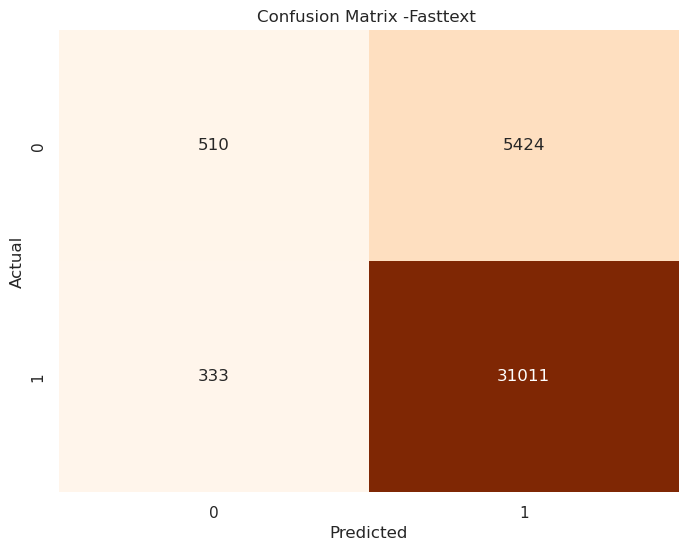

--------------------------------------------


In [49]:
random_forest(X_train_cb, X_test_cb, y_train_cb, y_test_cb, 'CBOW')
random_forest(X_train_sg, X_test_sg, y_train_sg, y_test_sg, 'Skipgram')
random_forest(X_train_ft, X_test_ft, y_train_ft, y_test_ft,'Fasttext')

### CNN

			FOR CBOW EMBEDDINGS
Class weights:  {0: 3.1411628396882234, 1: 0.5946552769270036}
Epoch 1/10
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6776 - loss: 0.6696 - val_accuracy: 0.6870 - val_loss: 0.6620 - learning_rate: 0.0100
Epoch 2/10
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6902 - loss: 0.6595 - val_accuracy: 0.7287 - val_loss: 0.6347 - learning_rate: 0.0100
Epoch 3/10
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6924 - loss: 0.6580 - val_accuracy: 0.6946 - val_loss: 0.6423 - learning_rate: 0.0100
Epoch 4/10
1150/1165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7039 - loss: 0.6571
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0019999999552965165.
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7040 - loss: 0.6572 - val_accuracy: 0.6911 - val_loss: 0.6393 - learning_rate: 0.0100
Epoch 5/10
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6896 - loss: 0.6528 - val_accuracy: 0.7004 - val_loss: 0.6447 - learning_rate

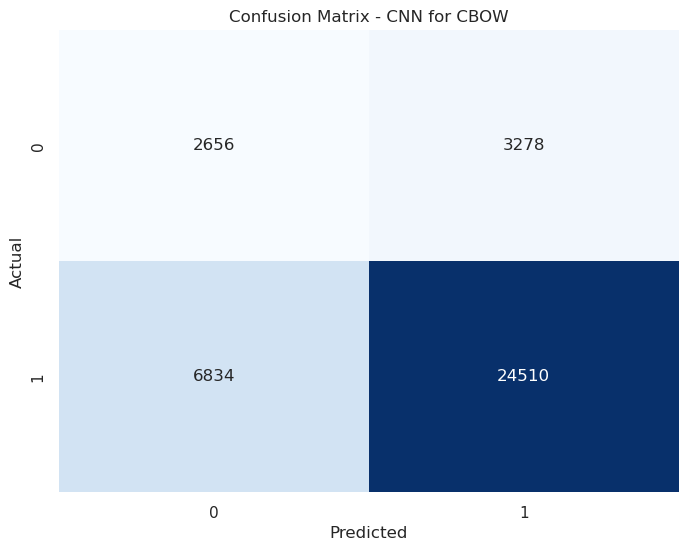

			FOR Skipgram EMBEDDINGS
Class weights:  {0: 3.1411628396882234, 1: 0.5946552769270036}
Epoch 1/10
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6928 - loss: 0.6650 - val_accuracy: 0.7688 - val_loss: 0.6414 - learning_rate: 0.0100
Epoch 2/10
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7416 - loss: 0.6521 - val_accuracy: 0.7581 - val_loss: 0.6351 - learning_rate: 0.0100
Epoch 3/10
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7398 - loss: 0.6505 - val_accuracy: 0.7566 - val_loss: 0.6287 - learning_rate: 0.0100
Epoch 4/10
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7384 - loss: 0.6502 - val_accuracy: 0.7640 - val_loss: 0.6250 - learning_rate: 0.0100
Epoch 5/10
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7416 - loss: 0.6487 - val_accuracy: 0.7642 - val_loss: 0.6371 - learning_rate: 0.0100
Epoch 6/10
1163/1165 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7402 - loss: 0.6498
Epoch 6: ReduceLROnPlateau reducing learning rate to

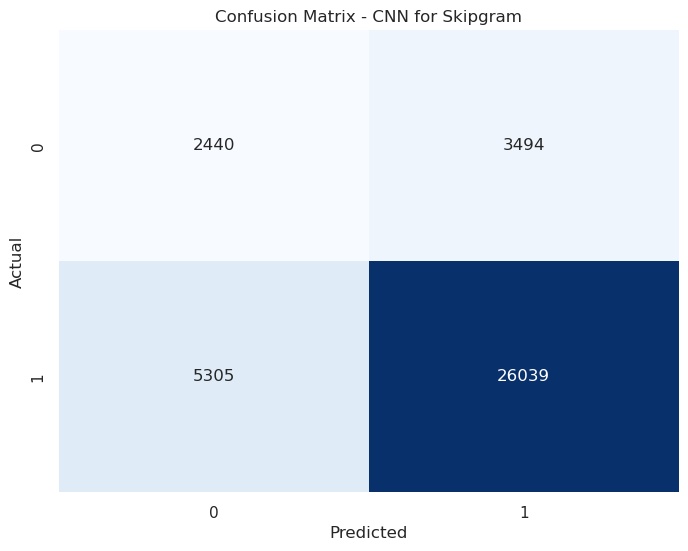

			FOR Fasttext EMBEDDINGS
Class weights:  {0: 3.1411628396882234, 1: 0.5946552769270036}
Epoch 1/10
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6738 - loss: 0.6599 - val_accuracy: 0.7496 - val_loss: 0.6536 - learning_rate: 0.0100
Epoch 2/10
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7234 - loss: 0.6479 - val_accuracy: 0.7517 - val_loss: 0.6442 - learning_rate: 0.0100
Epoch 3/10
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7324 - loss: 0.6460 - val_accuracy: 0.7466 - val_loss: 0.6430 - learning_rate: 0.0100
Epoch 4/10
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7333 - loss: 0.6455 - val_accuracy: 0.7399 - val_loss: 0.6481 - learning_rate: 0.0100
Epoch 5/10
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7352 - loss: 0.6439 - val_accuracy: 0.7644 - val_loss: 0.6148 - learning_rate: 0.0100
Epoch 6/10
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7389 - loss: 0.6412 - val_accuracy: 0.7599 - val_loss: 0.6183 - learning

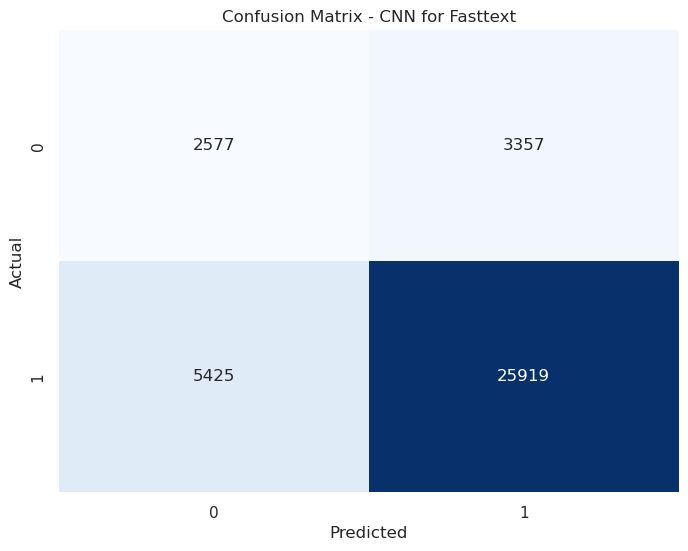

In [48]:
cnn(X_train_cb, X_test_cb, y_train_cb, y_test_cb, 'CBOW')
cnn(X_train_sg, X_test_sg, y_train_sg, y_test_sg, 'Skipgram')
cnn(X_train_ft, X_test_ft, y_train_ft, y_test_ft,'Fasttext')

### RNN

Class weights:  {0: 3.1411628396882234, 1: 0.5946552769270036}
Training RNN for CBOW embeddings with time_steps: 1 and input_dim: 10
Epoch 1/10
4660/4660 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.6763 - loss: 0.6796 - val_accuracy: 0.7212 - val_loss: 0.6583 - learning_rate: 0.0010
Epoch 2/10
4660/4660 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.7152 - loss: 0.6512 - val_accuracy: 0.7191 - val_loss: 0.6577 - learning_rate: 0.0010
Epoch 3/10
4660/4660 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.7055 - loss: 0.6509 - val_accuracy: 0.7162 - val_loss: 0.6586 - learning_rate: 0.0010
Epoch 4/10
4660/4660 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.7013 - loss: 0.6503 - val_accuracy: 0.7162 - val_loss: 0.6550 - learning_rate: 0.0010
Epoch 5/10
4660/4660 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.7052 - loss: 0.6488 - val_accuracy: 0.7191 - val_loss: 0.6524 - learning_rate: 0.0010
Epoch 6/10
4660/4660 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.7023 - loss: 0.6491 - val_acc

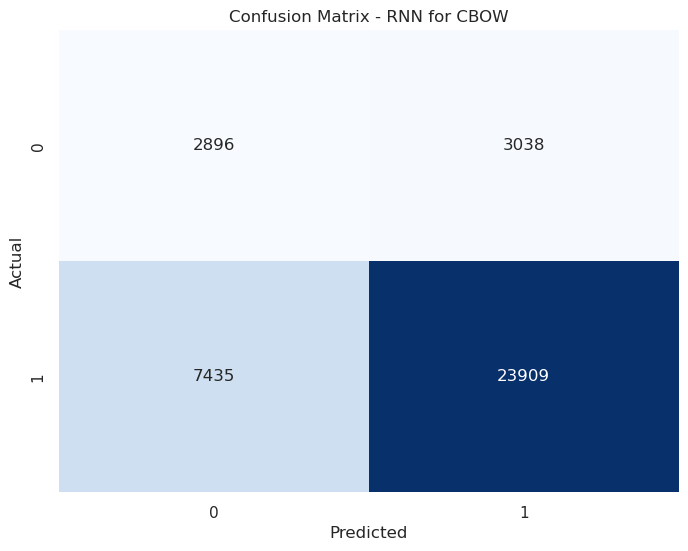

Class weights:  {0: 3.1411628396882234, 1: 0.5946552769270036}
Training RNN for Skipgram embeddings with time_steps: 1 and input_dim: 21
Epoch 1/10
4660/4660 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.7067 - loss: 0.6613 - val_accuracy: 0.7292 - val_loss: 0.6507 - learning_rate: 0.0010
Epoch 2/10
4660/4660 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.7264 - loss: 0.6468 - val_accuracy: 0.7319 - val_loss: 0.6474 - learning_rate: 0.0010
Epoch 3/10
4660/4660 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.7263 - loss: 0.6450 - val_accuracy: 0.7351 - val_loss: 0.6479 - learning_rate: 0.0010
Epoch 4/10
4660/4660 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.7278 - loss: 0.6433 - val_accuracy: 0.7341 - val_loss: 0.6468 - learning_rate: 0.0010
Epoch 5/10
4660/4660 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.7281 - loss: 0.6438 - val_accuracy: 0.7326 - val_loss: 0.6457 - learning_rate: 0.0010
Epoch 6/10
4660/4660 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.7278 - loss: 0.6444 - val

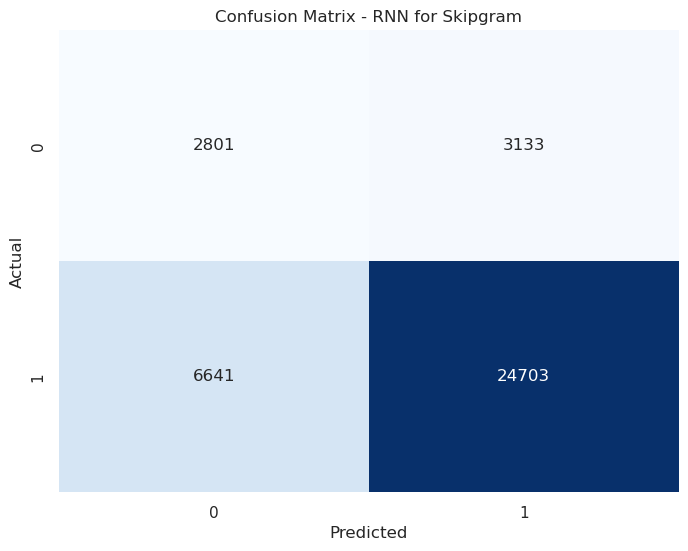

Class weights:  {0: 3.1411628396882234, 1: 0.5946552769270036}
Training RNN for Fasttext embeddings with time_steps: 1 and input_dim: 29
Epoch 1/10
4660/4660 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.7140 - loss: 0.6609 - val_accuracy: 0.7338 - val_loss: 0.6480 - learning_rate: 0.0010
Epoch 2/10
4660/4660 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.7314 - loss: 0.6400 - val_accuracy: 0.7385 - val_loss: 0.6436 - learning_rate: 0.0010
Epoch 3/10
4660/4660 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.7311 - loss: 0.6368 - val_accuracy: 0.7370 - val_loss: 0.6465 - learning_rate: 0.0010
Epoch 4/10
4660/4660 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.7313 - loss: 0.6364 - val_accuracy: 0.7409 - val_loss: 0.6393 - learning_rate: 0.0010
Epoch 5/10
4660/4660 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.7365 - loss: 0.6365 - val_accuracy: 0.7459 - val_loss: 0.6367 - learning_rate: 0.0010
Epoch 6/10
4660/4660 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.7391 - loss: 0.6348 - val

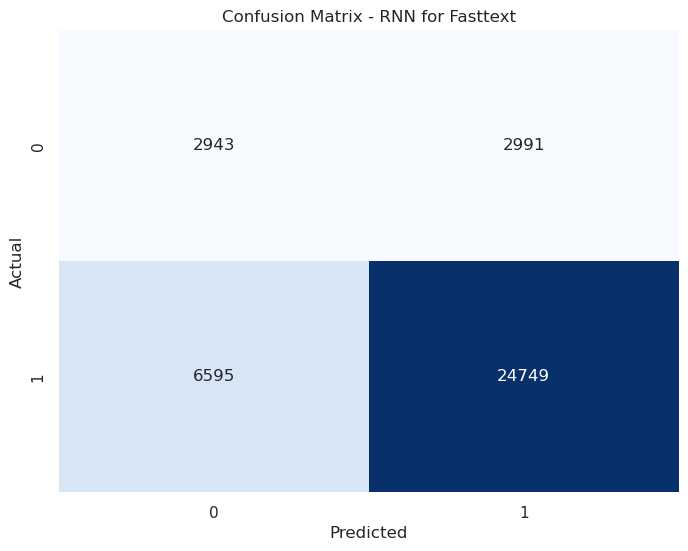

In [89]:
rnn(X_train_cb, X_test_cb, y_train_cb, y_test_cb, 'CBOW')
rnn(X_train_sg, X_test_sg, y_train_sg, y_test_sg, 'Skipgram')
rnn(X_train_ft, X_test_ft, y_train_ft, y_test_ft,'Fasttext')

## Sentiment Analysis using Textblob and Vader

In [ ]:
!pip install vaderSentiment

In [ ]:
!pip install textblob

Sentiment analysis on the first 1000 reviews using vader and textblob


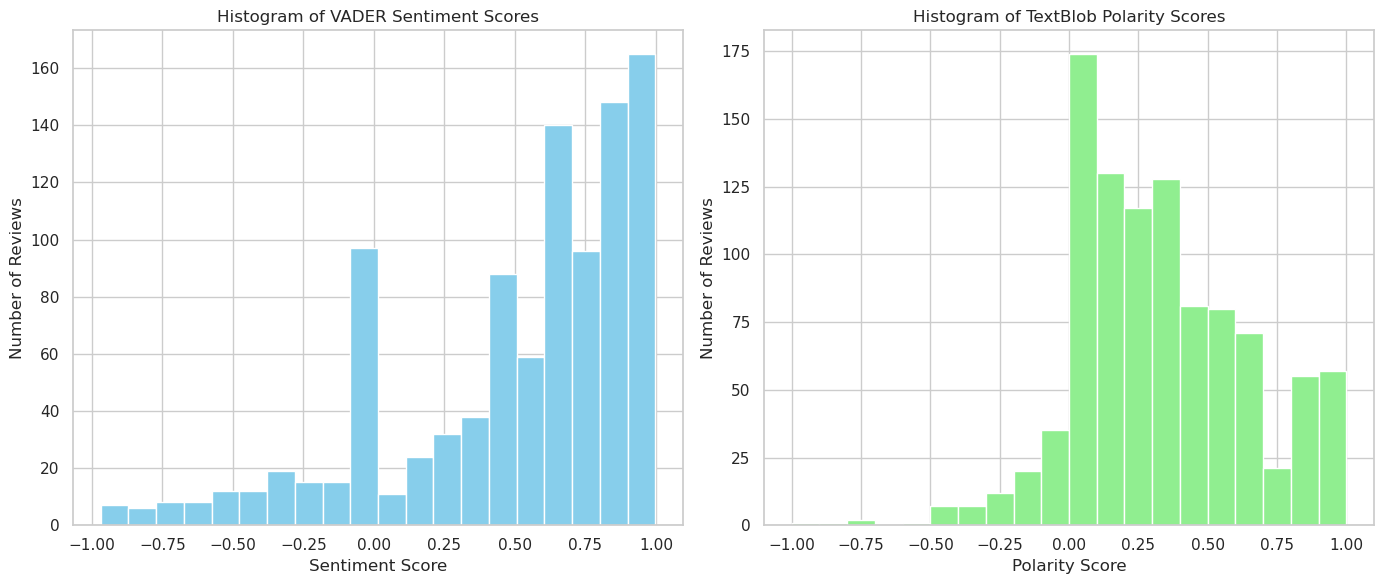

In [79]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

df =  merged_df[:1000]
df = df.loc[:, ['reviewText']]

analyzer = SentimentIntensityAnalyzer()

def vader_sentiment(text):
    score = analyzer.polarity_scores(text)
    return score['compound']

def textblob_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

# Apply VADER sentiment analysis to the reviewText column
df['vader_sentiment'] = df['reviewText'].apply(vader_sentiment)

# Apply TextBlob sentiment analysis to the reviewText column
df['textblob_sentiment'] = df['reviewText'].apply(textblob_sentiment)

print("Sentiment analysis on the first 1000 reviews using vader and textblob")
df

import matplotlib.pyplot as plt
 
plt.figure(figsize=(14, 6))
 
plt.subplot(1, 2, 1)
plt.hist(df['vader_sentiment'], bins=20, color='skyblue')
plt.title('Histogram of VADER Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Number of Reviews')
 
plt.subplot(1, 2, 2)
plt.hist(df['textblob_sentiment'], bins=20, color='lightgreen')
plt.title('Histogram of TextBlob Polarity Scores')
plt.xlabel('Polarity Score')
plt.ylabel('Number of Reviews')
 
plt.tight_layout()
plt.show()

We can see that by taking just the first 1000 reviewTexts, VADER and TextBlob give different polarity/sentiment scores. VADER results tell that the reviews are more 'positively' distributed, whereas TextBlob infers that most of the reviews are neutral in sentiment. 

## Result Analysis

In [73]:
# Table of results - ONLY ACCURACY SCORES
df = pd.DataFrame({'Classification model': ['Logistic Regression', 'Random Forest', 'CNN', 'RNN'],
                   'CBOW': [0.8369,0.8414,0.7287,0.7190],
                   'Skipgram': [0.8389, 0.8429, 0.7649, 0.7378],
                   'Fasttext': [0.8367, 0.8455, 0.7644, 0.7428]})

# Melt the DataFrame to make it long-form
df_melted = df.melt(id_vars='Classification model', var_name='Embedding', value_name='Accuracy')

df


,Classification model,CBOW,Skipgram,Fasttext
0,Logistic Regression,0.8369,0.8389,0.8367
1,Random Forest,0.8414,0.8429,0.8455
2,CNN,0.7287,0.7649,0.7644
3,RNN,0.7190,0.7378,0.7428


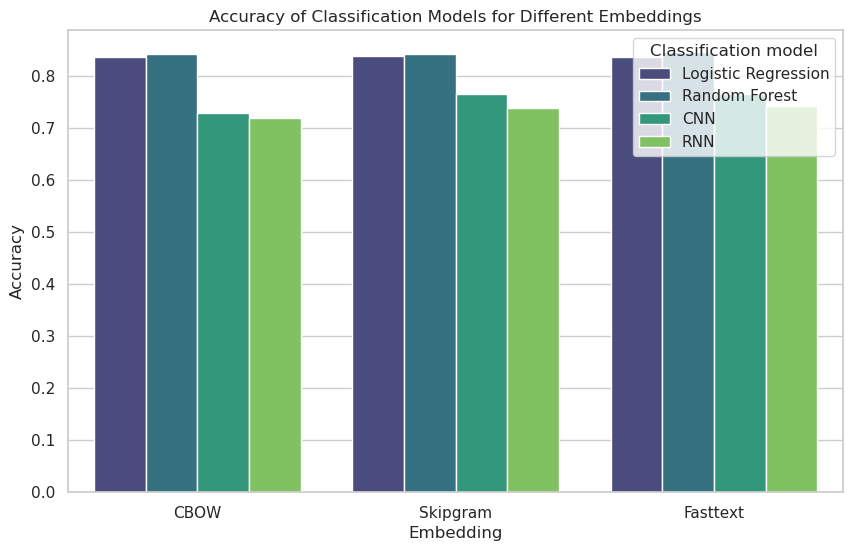

In [76]:
# Plot the results
plt.figure(figsize=(10, 6))
sns.barplot(x='Embedding', y='Accuracy', hue='Classification model', data=df_melted, palette='viridis')
plt.title('Accuracy of Classification Models for Different Embeddings')
plt.ylabel('Accuracy')
plt.show()

### Comparitive Analysis of our work:
#### Note: the previous table and plot are only accuracy scores and they cannot solely be used to explain each embedding models efficiency.

From the scores and confusion matrix plots in all the 4 classification models(logreg, randomforest, cnn & rnn) these are the insights we could come up with:
- Just looking at the accuracy scores/f-1 scores lead us to conclude that Logistic regression and random-forest were the best classification models but in reality looking at the confusion matrix and ROC-AUC score indicated that the model's ability to discriminate between the 2 classes is no better than a random guessing operation. So we think that logreg and random forest might not be the best approach to evaluate and differentiate between the efficiencies of the 3 embedding models.

- Now coming to CNN and RNN for all the 3 embedding techniques we have gotten a similar accuracy score(lower than logistic regression and random forest). Although the scores are lower, in all the 6 cases(CNN for 3 embeddings + RNN for 3 embeddings) the confusion matrices tell us that in all 6 cases more true negatives were being classified. For eg, in logistic regression only around 100 true negatvies were correctly classified. But in CNN and RNN over 2000 of them were classified right. 
- Individually assessing the 3 embedding techniques all of them give a high recall score indicating that the true positives could easily be identified. We think this is due to the nature of the data as there are actually way more positive reviews than the negative reviews with a ratio of 1:10. Though we accomodated for the class imbalance by making use of the 'class_weights' parameter offered by keras, the models still show a tendancy to classify positives better than the negative 
- False Positives (FP): The number of FPs is significant across all models, indicating a tendency of models to incorrectly classify negative instances as positive. This could suggest that the models are biased towards predicting the majority class, a common issue in imbalanced datasets.
- False Negatives (FN): The FN counts are also high, particularly in RNN models, indicating missed opportunities to identify true positive instances. The relatively higher FN in RNN models compared to CNN models suggests that CNNs might be better at capturing relevant features for classification in this context.
- True Positives (TP): All models show a strong ability to identify true positive instances, with the CNN models generally outperforming the RNN models. This performance indicates that, despite the challenges with FPs and FNs, the models are still capturing meaningful patterns in the data.
- True Negatives (TN): TN counts are the lowest among all the components of the confusion matrices, which points to a challenge in correctly identifying true negative instances. The models' performance on TNs could be improved to enhance overall model accuracy and reliability.


Considering the balance between accuracy, precision, recall, and the F1 score, the Skip-gram CNN and FastText CNN models emerge as the most optimal models. Their higher recall rates make them particularly valuable for applications where it's crucial to minimize false negatives such as this sentiment analysis.  
Between these two, the choice may come down to specific application requirements: Skip-gram CNN slightly leads in recall, while FastText CNN offers the best precision and is slightly more accurate.

